---
title: Python Assignment 3
subtitle: Efficient Frontier
author: Brady Bulls
date: today
date-format: "MMMM D YYYY"
format:
  html:
    theme: sandstone
    toc: false
warning: false
---

## Part A:

### Step 3: Review and modify collab code

In [15]:
import math as m
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'serif'

import warnings; warnings.simplefilter('ignore')

In [16]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [17]:
def random_portfolio(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std
    return results, weights_record

#### Collecting S&P 500 tickers from the web

In [18]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]

In [19]:
stocks_sp500 = sp500_constituents['Symbol']

In [20]:
# Transpose the oclumn vector to a row vector and covert pandas into a list.
tickers = stocks_sp500.T
tickers = tickers.values.tolist()

tickers.remove('BF.B')
tickers.remove('BRK.B')

In [21]:
type(tickers)

list

In [22]:
len(tickers)

501

In [23]:
import scipy.optimize as sco

In [24]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [25]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [26]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]
    
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0, 1.0) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [34]:
def display_ef_with_selected2(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252

    max_sharpe2 = (rp - risk_free_rate)/ sdp

    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualized Return:", round(rp,2))
    print ("Annualized Volatility:", round(sdp,2))
    print ("Sharpe ratio =", max_sharpe)
    print ("Sharpe ratio2 =", round(max_sharpe2, 4))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualized Return:", round(rp_min,2))
    print ("Annualized Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(data.columns):
        print (txt,":","annualized return",round(an_rt[i],2),", annualized volatility:",round(an_vol[i],2))
    print ("-"*80)

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualized volatility')
    ax.set_ylabel('annualized returns')
    ax.legend(labelspacing=0.8)
    
    return max_sharpe_allocation, max_sharpe2

In [28]:
import random
stocks = random.sample(tickers, 10)
stocks

data = pd.DataFrame()
data = yf.download(stocks, start="2017-01-01", end="2023-12-31", progress=True)['Adj Close'].dropna()


returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios= 5000
risk_free_rate = 0.0378

[*********************100%%**********************]  10 of 10 completed


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.29
Annualized Volatility: 0.3
Sharpe ratio =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8437966417302262
       x: [ 2.668e-01  1.807e-02  4.852e-17  0.000e+00  4.975e-01
            4.494e-02  0.000e+00  7.752e-18  1.727e-01  3.944e-17]
     nit: 8
     jac: [-1.245e-01 -1.243e-01  1.290e-01 -1.329e-02 -1.249e-01
           -1.235e-01 -7.518e-02 -1.184e-01 -1.242e-01  1.635e-01]
    nfev: 89
    njev: 8
Sharpe ratio2 = 0.8438


Ticker        ACN  ALGN  AVB  CCI   LRCX  MKTX  PSX  SYK    TJX  ZION
allocation  26.68  1.81  0.0  0.0  49.75  4.49  0.0  0.0  17.27   0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.14
Annualized Volatility: 0.2


Ticker        ACN  ALGN    AVB    CCI  LRCX   MKTX   PSX  SYK  

Ticker,ACN,ALGN,AVB,CCI,LRCX,MKTX,PSX,SYK,TJX,ZION
allocation,26.68,1.81,0.0,0.0,49.75,4.49,0.0,0.0,17.27,0.0


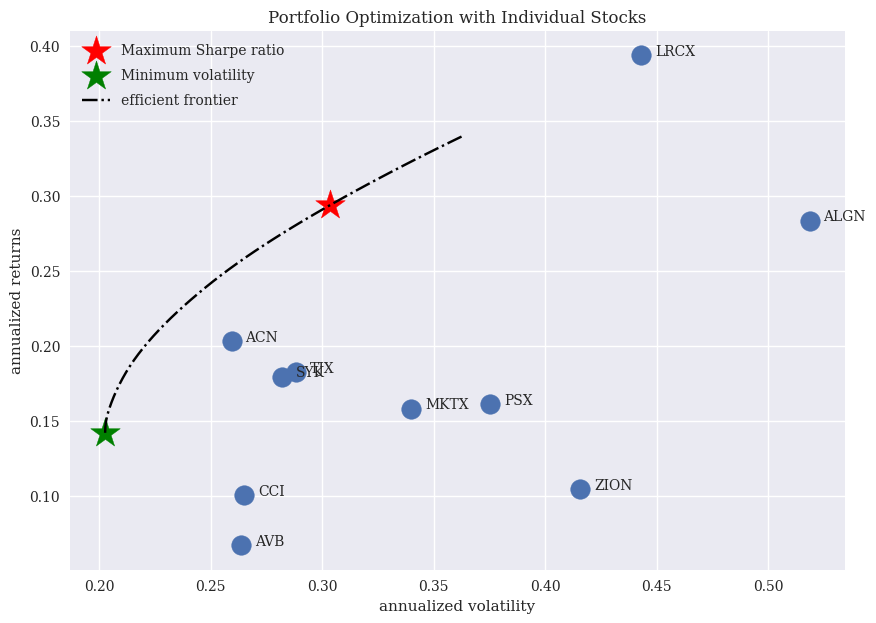

In [37]:
%%time

looping = 1000

max_iterated_SR = 0
max_allocation = pd.DataFrame()

for i in range(looping):
    stocks = random.sample(tickers, 10)
    data = pd.DataFrame()
    # I passed the list to yf.download instead of a for loop to try and reduce
    # the number of yahoo calls.
    data = yf.download(stocks, start="2017-01-01", end="2023-12-31", progress=False)['Adj Close'].dropna()

returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 5000
risk_free_rate = 0.0378

max2, max_SR = display_ef_with_selected2(mean_returns, cov_matrix, risk_free_rate)
if max_SR >= max_iterated_SR:
    max_iterated_SR = max_SR
    max_allocation = max2

print(f'The Highest SR={max_iterated_SR:.4f}')
print('\n')
print('\n')

max_allocation

{{< pagebreak >}}

### Step 4: The Hilpisch Code

In [40]:
import math as m
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm

import matplotlib.pyplot as plt

import yfinance as yf

plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [41]:
def normality_test(arr):
    '''Tests or normality distribution of given data set.
    
    Prametters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    print('Skew of data set %14.3f' % scs.skew(arr))
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    print('Kurt of data set %14.3f' % scs.kurtosis(arr))
    print('Kurt test p-values %14.3f' % scs.kurtosistest(arr)[1])
    print('Norm test p-values %14.3f' % scs.normaltest(arr)[1])

In [43]:
def print_statistcis(array):
    ''' prints selected statistics.
    
    Paramaters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    sta = scs.describe(array)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * '-')
    print('%14s %15.5f' % ('size', sta[0]))
    print('%14s %15.5f' % ('max', sta[1][1]))
    print('%14s %15.5f' % ('mean', sta[2]))
    print('%14s %15.5f' % ('annual mean', sta[2]*252))
    print('%14s %15.5f' % ('std', np.sqrt(sta[3])))
    print('%14s %15.5f' % ('annual std', np.sqrt(sta[3]*np.sqrt(252))))
    print('%14s %15.5f' % ('skew', sta[4]))
    print('%14s %15.5f' % ('kurtosis', sta[5]))

In [47]:
tickers = ['SPY', 'GLD', 'AAPL', 'MSFT']
mydata = pd.DataFrame()
mydata = yf.download(tickers, start='2010-01-01', end='2020-06-29')['Adj Close']
mydata.isna().any()

[*********************100%%**********************]  4 of 4 completed


Ticker
AAPL    False
GLD     False
MSFT    False
SPY     False
dtype: bool

In [48]:
for t in tickers:
    print(t)
    print_statistcis(mydata[t].pct_change().dropna())

    print(30 * '-')

SPY
     statistic           value
------------------------------
          size      2638.00000
           max         0.09060
          mean         0.00051
   annual mean         0.12814
           std         0.01089
    annual std         0.04340
          skew        -0.60333
      kurtosis        13.90910
------------------------------
GLD
     statistic           value
------------------------------
          size      2638.00000
           max         0.04904
          mean         0.00021
   annual mean         0.05230
           std         0.00995
    annual std         0.03963
          skew        -0.41236
      kurtosis         5.14647
------------------------------
AAPL
     statistic           value
------------------------------
          size      2638.00000
           max         0.11981
          mean         0.00113
   annual mean         0.28601
           std         0.01741
    annual std         0.06936
          skew        -0.14358
      kurtosis         6.3

In [49]:
data = mydata
data = data.dropna()
data

Ticker,AAPL,GLD,MSFT,SPY
Date,,,,
2010-01-04,6.572423,109.800003,23.994564,90.493996
2010-01-05,6.583786,109.699997,24.002319,90.733574
2010-01-06,6.479064,111.510002,23.855013,90.797455
2010-01-07,6.467087,110.820000,23.606922,91.180725
2010-01-08,6.510081,111.370003,23.769743,91.484131
...,...,...,...,...
2020-06-22,89.117027,165.089996,198.646606,306.061371
2020-06-23,91.019203,166.479996,199.973740,307.470337
2020-06-24,89.412537,165.899994,195.942780,299.627167


<Axes: xlabel='Date'>

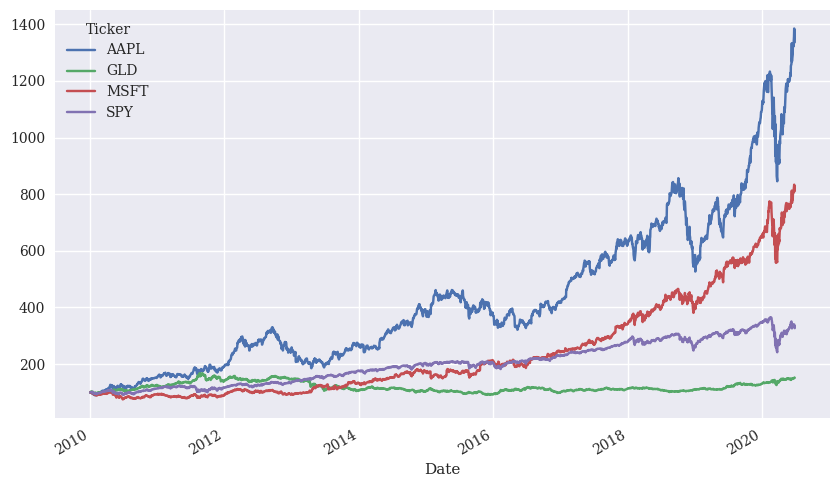

In [50]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))
# plt.savefig()

In [53]:
log_returns = np.log(data / data.shift(1)).dropna()
log_returns.head()

Ticker,AAPL,GLD,MSFT,SPY
Date,,,,
2010-01-05,0.001727,-0.000911,0.000323,0.002644
2010-01-06,-0.016034,0.016365,-0.006156,0.000704
2010-01-07,-0.001850,-0.006207,-0.010454,0.004212
2010-01-08,0.006626,0.004951,0.006873,0.003322
2010-01-11,-0.008861,0.013201,-0.012802,0.001396


array([[<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'GLD'}>],
       [<Axes: title={'center': 'MSFT'}>,
        <Axes: title={'center': 'SPY'}>]], dtype=object)

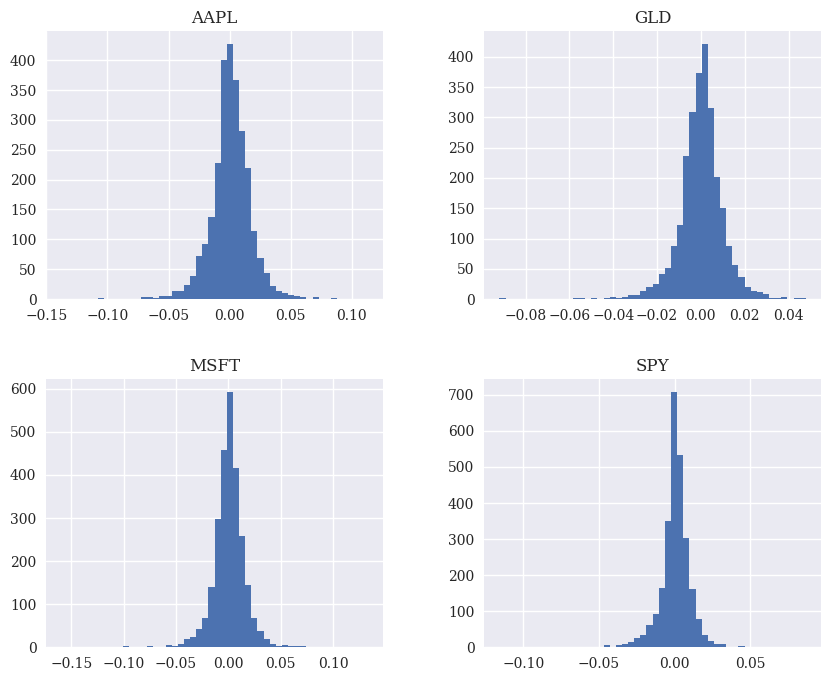

In [55]:
log_returns.hist(bins=50, figsize=(10, 8))
# plt.savefig()

In [56]:
for sym in tickers:
    print('\nResults for symbol {}'.format(sym))
    print(30 * '-')
    log_data = np.array(log_returns[sym].dropna())
    print_statistcis(log_data)


Results for symbol SPY
------------------------------
     statistic           value
------------------------------
          size      2638.00000
           max         0.08673
          mean         0.00045
   annual mean         0.11309
           std         0.01093
    annual std         0.04356
          skew        -0.86337
      kurtosis        14.87487

Results for symbol GLD
------------------------------
     statistic           value
------------------------------
          size      2638.00000
           max         0.04787
          mean         0.00016
   annual mean         0.03979
           std         0.00997
    annual std         0.03972
          skew        -0.51985
      kurtosis         5.62429

Results for symbol AAPL
------------------------------
     statistic           value
------------------------------
          size      2638.00000
           max         0.11316
          mean         0.00098
   annual mean         0.24764
           std         0.017

Text(0, 0.5, 'sample quantiles')

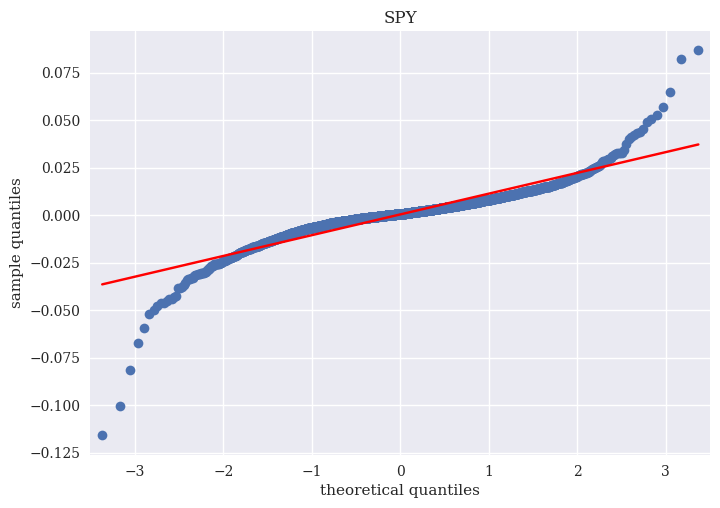

In [57]:
sm.qqplot(log_returns['SPY'].dropna(), line='s')
plt.title('SPY')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')
# plt.savefig()

### Rejecting Normality

In [59]:
for sym in tickers:
    print('\nResults for symbol {}'.format(sym))
    print(32 * '-')
    log_data = np.array(log_returns[sym].dropna())
    normality_test(log_data)


Results for symbol SPY
--------------------------------
Skew of data set         -0.863
Skew test p-value          0.000
Kurt of data set         14.875
Kurt test p-values          0.000
Norm test p-values          0.000

Results for symbol GLD
--------------------------------
Skew of data set         -0.520
Skew test p-value          0.000
Kurt of data set          5.624
Kurt test p-values          0.000
Norm test p-values          0.000

Results for symbol AAPL
--------------------------------
Skew of data set         -0.366
Skew test p-value          0.000
Kurt of data set          6.804
Kurt test p-values          0.000
Norm test p-values          0.000

Results for symbol MSFT
--------------------------------
Skew of data set         -0.233
Skew test p-value          0.000
Kurt of data set         11.286
Kurt test p-values          0.000
Norm test p-values          0.000


{{< pagebreak >}}

### Portfolio Optimization

#### The Data